# Moving Obstacles

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Moving_Obstacles.ipynb)

This example shows how to add moving obstacles to a fluid simulation.

In [ ]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

We define our domain size and the obstacle behavior.
A cube and sphere should move with constant velocity through the domain.
Each step, the obstacle positions are incremented by $v \cdot \Delta t$.

In [33]:
domain = Box(x=100, y=100)
obstacles = [
    Obstacle(Cuboid(vec(x=20, y=80), x=20, y=20), velocity=vec(x=5., y=0)),
    Obstacle(Sphere(x=20, y=20, radius=10), velocity=vec(x=1, y=4)),
]

def move_obstacle(obs: Obstacle, dt):
    x = (obs.geometry.center + obs.velocity * dt) % domain.size
    return obs.at(x)

move_obstacles = lambda *obstacles, dt: tuple([move_obstacle(o, dt) for o in obstacles])

Let's sketch out the path the obstacles are going to take. We stack snapshots at different times along the `time` dimension which we make *spatial* in order to draw the snapshots with connecting lines.

<Figure size 864x360 with 1 Axes>

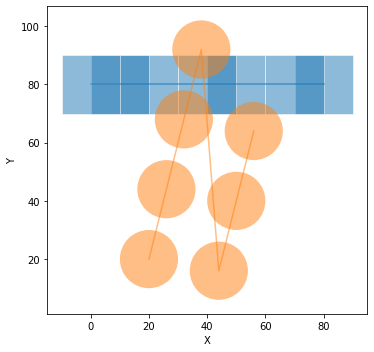

In [34]:
obs_trj = iterate(move_obstacles, spatial(time=6), *obstacles, dt=6.)
plot([o.geometry for o in obs_trj], alpha=.5, overlay='list')

Next, we define the simulation and run it.

In [19]:
@jit_compile
def step(v, p, obs1, obs2, dt=.5):
    obs1, obs2 = move_obstacles(obs1, obs2, dt=dt)
    v = advect.mac_cormack(v, v, dt)
    v, p = fluid.make_incompressible(v, (obs1, obs2), Solve(x0=p))
    return v, p, obs1, obs2

In [35]:
v0 = StaggeredGrid(0, PERIODIC, domain, x=100, y=100)
v_trj, p_trj, *obs_trjs = iterate(step, batch(time=130), v0, None, *obstacles, range=trange)

  0%|          | 0/130 [00:00<?, ?it/s]

In [42]:
plot(*[o.geometry for o in obs_trjs], v_trj.curl(), animate='time', overlay='args')